In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_excel('data_full_5sekres.xlsx')

In [63]:
df1 = df.copy()

In [64]:
#Create a column of load profile
df1['Load'] = df1['thrusterAndPropulsion']
df1['BaseLoad'] = 300
df1.loc[df1['operationId'] == 100, 'BaseLoad'] = 500
df1.loc[df1['operationId'] == 3, 'BaseLoad'] = 550
df1.loc[df1['operationId'] == 5, 'BaseLoad'] = 510
df1.loc[df1['operationId'] == 6, 'BaseLoad'] = 250
df1.loc[df1['operationId'] == 1, 'BaseLoad'] = 250
df1.loc[df1['operationId'] == 7, 'BaseLoad'] = 380

df1['Load'] = df1['thrusterAndPropulsion'] + df1['BaseLoad']

df1['Battery'] = 0
df1['SOC'] = 0
#Create dataset with only relevant columns
df3 = df1[['datetime', 'Load', 'engMdoPower_0_','engMdoPower_1_','engMdoPower_2_', 'engMdoPower_3_', 'operationId', 'BaseLoad', 'Battery', 'SOC']]

#Set engine powers to zero
num = df3['engMdoPower_0_']._get_numeric_data()
num[num != 0] = 0

num = df3['engMdoPower_1_']._get_numeric_data()
num[num != 0] = 0

num = df3['engMdoPower_2_']._get_numeric_data()
num[num != 0] = 0

num = df3['engMdoPower_3_']._get_numeric_data()
num[num != 0] = 0


# Peakshaving for 5-10 seconds over 2100

In [94]:
df6 = df3.copy()

load = df6['Load'].values
dg0 = df6['engMdoPower_0_'].values
dg1 = df6['engMdoPower_1_'].values
dg2 = df6['engMdoPower_2_'].values
dg3 = df6['engMdoPower_3_'].values
bat = df6['Battery'].values
soc = [0]*120960
soc[0] = 496 #124 empty (20%) 496(80%)
opid = df6['operationId'].values
shore = [0]*120960
efbat = 0.92

# DP mode, battery is used for spinning reserve 
for i in range(len(load)):
    if i == 120959:
        pass
    elif opid[i] == 100:
        
        if load[i] <= 2100 and soc[i] >= 200:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] <= 2100 and soc[i] < 200:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
            
        elif load[i] > 2100 and soc[i] >= 200:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        elif load[i] > 2100 and soc[i] < 200:
            dg0[i] = dg1[i] = dg3[i] = load[i]/3
            soc[i+1] = soc[i]         

        else:
            soc[i+1] = soc[i]
            
#Transit mode
    elif opid[i] == 3 or opid[i] == 5:
        if load[i] <= 1000 and soc[i] < 496:
            dg0[i] = 1000
            bat[i] = load[i] - dg0[i]
            soc[i+1] = soc[i] - (bat[i]*efbat)/720
        elif load[i] <= 1000 and soc[i] >= 496:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] <= 2100 and load[i+1] <= 2100 and load[i] > 1000:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] <= 2100 and load[i+1] > 2100 and load[i] > 1000:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] > 2100 and load[i-1] < 2100 and soc[i] > 124: # if the load is over 2100 for less than 5 seconds battery covers
            dg0[i] = 2100
            bat[i] = load[i] - dg0[i]
            soc[i+1] = soc[i] - bat[i]/720
        elif load[i] > 2100 and load[i-2] < 2100 and soc[i] > 124: # if the load is over 2100 for less than 10 seconds battery covers
            dg0[i] = 2100
            bat[i] = load[i] - dg0[i]
            soc[i+1] = soc[i] - bat[i]/720            
        elif load[i] > 2100 and load[i-1] < 2100 and soc[i] <= 124: # if the load is over 2100 for less than 5 seconds battery covers
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        elif load[i] > 2100 and load[i-2] < 2100 and soc[i] <= 124: # if the load is over 2100 for less than 10 seconds battery covers
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]           
        elif load[i] <= 4200 and load[i-1] > 2100:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        elif load[i] > 4200:
            dg0[i] = dg1[i] = 2100
            bat[i] = load[i] - dg0[i] - dg1[i]
            soc[i+1] = soc[i] - bat[i]/720
        else:
            soc[i+1] = soc[i]
        
#Standby mode
    elif opid[i] == 7 :
        if load[i] <= 1000 and soc[i] < 496:
            dg0[i] = 1000
            bat[i] = load[i] - dg0[i]
            soc[i+1] = soc[i] - (bat[i]*efbat)/720
        elif load[i] <= 1000 and soc[i] >= 496:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] <= 2100 and load[i+1] <= 2100 and load[i] > 1000:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] <= 2100 and load[i+1] > 2100 and load[i] > 1000:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] > 2100 and load[i-1] < 2100 and soc[i] > 124: # if the load is over 2100 for less than 5 seconds battery covers
            dg0[i] = 2100
            bat[i] = load[i] - dg0[i]
            soc[i+1] = soc[i] - bat[i]/720
        elif load[i] > 2100 and load[i-2] < 2100 and soc[i] > 124: # if the load is over 2100 for less than 10 seconds battery covers
            dg0[i] = 2100
            bat[i] = load[i] - dg0[i]
            soc[i+1] = soc[i] - bat[i]/720            
        elif load[i] > 2100 and load[i-1] < 2100 and soc[i] <= 124: # if the load is over 2100 for less than 5 seconds battery covers
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        elif load[i] > 2100 and load[i-2] < 2100 and soc[i] <= 124: # if the load is over 2100 for less than 10 seconds battery covers
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]           
        elif load[i] <= 4200 and load[i-1] > 2100:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        elif load[i] > 4200:
            dg0[i] = dg1[i] = 2100
            bat[i] = load[i] - dg0[i] - dg1[i]
            soc[i+1] = soc[i] - bat[i]/720
        else:
            soc[i+1] = soc[i]
            
# port
    elif opid[i] == 1 and soc[i] < 496:
        #bat[i] = -100
        dg0[i] = load[i]# - bat[i]*1.08
        soc[i+1] = soc[i]# - bat[i]/720
    elif opid[i] == 1 and soc[i] >= 496:
        dg0[i] = load[i]
        soc[i+1] = soc[i]    
    elif opid[i] == 6 and soc[i] < 496:
        bat[i] = -100
        shore[i] = load[i]
        dg0[i] = - bat[i]
        soc[i+1] = soc[i] - (bat[i]*efbat)/720
    elif opid[i] == 6 and soc[i] >= 496:
        shore[i] = load[i]
        soc[i+1] = soc[i] 
    else:
        soc[i+1] = soc[i]

    

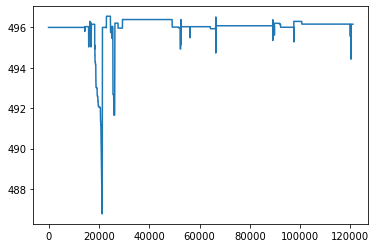

In [95]:
plt.plot(soc)#[18500:20530])
#plt.plot(opid[18500:20530])

In [96]:
# Normalize Generators
dg0n = (dg0-dg0.min()) / (2100 - dg0.min())
dg1n = (dg1-dg1.min()) / (2100 - dg1.min())
dg2n = (dg2-dg2.min()) / (2100 - dg2.min())
dg3n = (dg3-dg3.min()) / (2100 - dg3.min())


In [97]:
fc_dg0 = np.zeros(120960)
fc_dg1 = np.zeros(120960)
fc_dg2 = np.zeros(120960)
fc_dg3 = np.zeros(120960)

for i in range(len(dg0)):
    if dg0[i] == 0:
        fc_dg0[i] = 0
    else:
        fc_dg0[i] = (445*dg0n[i] + 47)/720
        
for i in range(len(dg1)):
    if dg1[i] == 0:
        fc_dg1[i] = 0
    else:
        fc_dg1[i] = (445*dg1n[i] + 47)/720
        
for i in range(len(dg2)):
    if dg2[i] == 0:
        fc_dg2[i] = 0
    else:
        fc_dg2[i] = (445*dg2n[i] + 47)/720
        
for i in range(len(dg3)):
    if dg3[i] == 0:
        fc_dg3[i] = 0
    else:
        fc_dg3[i] = (445*dg3n[i] + 47)/720

In [98]:
fc = sum(fc_dg0) + sum(fc_dg1) + sum(fc_dg2) + sum(fc_dg3)
print('Total fuel consumption of BASECASE med batteri 20% batteri start er: ', fc, 'liter')

Total fuel consumption of BASECASE med batteri 20% batteri start er:  39812.02058185197 liter


# Battery peak shaves between 1 and 2 generators

Change soc[0] on line 10 for different scenarios

In [99]:
df4 = df3.copy()

load = df4['Load'].values
dg0 = df4['engMdoPower_0_'].values
dg1 = df4['engMdoPower_1_'].values
dg2 = df4['engMdoPower_2_'].values
dg3 = df4['engMdoPower_3_'].values
bat = df4['Battery'].values
soc = [0]*120960
soc[0] = 496 #124 empty (20%) 496(80%)
opid = df4['operationId'].values
shore = [0]*120960
efbat = 0.92 # battery efficiency


# DP mode, battery is used for spinning reserve 
for i in range(len(load)):
    if i == 120959:
        pass
    elif opid[i] == 100:
        
        if load[i] <= 2100 and soc[i] >= 200:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] <= 2100 and soc[i] < 200:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
            
        elif load[i] > 2100 and soc[i] >= 200:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        elif load[i] > 2100 and soc[i] < 200:
            dg0[i] = dg1[i] = dg3[i] = load[i]/3
            soc[i+1] = soc[i]         

        else:
            soc[i+1] = soc[i]

#Transit mode
    elif opid[i] == 3 or opid[i] == 5:
        if load[i] <= 1000 and soc[i] < 496:
            dg0[i] = 1000
            bat[i] = load[i] - dg0[i]
            soc[i+1] = soc[i] - (bat[i]*efbat)/720
        elif load[i] <= 1000 and soc[i] >= 496:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] <= 2100 and load[i] > 1000:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] > 2100 and load[i] <= 3000 and soc[i] > 124: # if the load is over 2100 for less than 5 seconds battery covers
            dg0[i] = 2100
            bat[i] = load[i] - dg0[i]
            soc[i+1] = soc[i] - bat[i]/720
        elif load[i] > 2100 and load[i] <= 3000 and soc[i] <= 124: # if the load is over 2100 for less than 5 seconds battery covers
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        elif load[i] > 3000: # if the load is over 2100 for less than 5 seconds battery covers
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        else:
            soc[i+1] = soc[i]
        
#Standby mode
    elif opid[i] == 7:
        if load[i] <= 1000 and soc[i] < 496:
            dg0[i] = 1000
            bat[i] = load[i] - dg0[i]
            soc[i+1] = soc[i] - (bat[i]*efbat)/720
        elif load[i] <= 1000 and soc[i] >= 496:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] <= 2100 and load[i] > 1000:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] > 2100 and load[i] <= 3000 and soc[i] > 124: # if the load is over 2100 for less than 5 seconds battery covers
            dg0[i] = 2100
            bat[i] = load[i] - dg0[i]
            soc[i+1] = soc[i] - bat[i]/720
        elif load[i] > 2100 and load[i] <= 3000 and soc[i] <= 124: # if the load is over 2100 for less than 5 seconds battery covers
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        elif load[i] > 3000: # if the load is over 2100 for less than 5 seconds battery covers
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        else:
            soc[i+1] = soc[i]
            
# port
    elif opid[i] == 1 and soc[i] < 496:
        #bat[i] = -100
        dg0[i] = load[i]# - bat[i]*1.08
        soc[i+1] = soc[i]# - bat[i]/720
    elif opid[i] == 1 and soc[i] >= 496:
        dg0[i] = load[i]
        soc[i+1] = soc[i]    
    elif opid[i] == 6 and soc[i] < 496:
        bat[i] = -100
        shore[i] = load[i]
        dg0[i] = -bat[i]                #1.08 because 92% efficiency
        soc[i+1] = soc[i] - (bat[i]*efbat)/720
    elif opid[i] == 6 and soc[i] >= 496:
        shore[i] = load[i]
        soc[i+1] = soc[i] 
    else:
        soc[i+1] = soc[i]



In [100]:
# Normalize Generators
dg0n = (dg0-dg0.min()) / (2100 - dg0.min())
dg1n = (dg1-dg1.min()) / (2100 - dg1.min())
dg2n = (dg2-dg2.min()) / (2100 - dg2.min())
dg3n = (dg3-dg3.min()) / (2100 - dg3.min())

fc_dg0 = np.zeros(120960)
fc_dg1 = np.zeros(120960)
fc_dg2 = np.zeros(120960)
fc_dg3 = np.zeros(120960)

for i in range(len(dg0)):
    if dg0[i] == 0:
        fc_dg0[i] = 0
    else:
        fc_dg0[i] = (445*dg0n[i] + 47)/720
        
for i in range(len(dg1)):
    if dg1[i] == 0:
        fc_dg1[i] = 0
    else:
        fc_dg1[i] = (445*dg1n[i] + 47)/720
        
for i in range(len(dg2)):
    if dg2[i] == 0:
        fc_dg2[i] = 0
    else:
        fc_dg2[i] = (445*dg2n[i] + 47)/720
        
for i in range(len(dg3)):
    if dg3[i] == 0:
        fc_dg3[i] = 0
    else:
        fc_dg3[i] = (445*dg3n[i] + 47)/720
        
fc = sum(fc_dg0) + sum(fc_dg1) + sum(fc_dg2) + sum(fc_dg3)
print('Total fuel consumption of BASECASE med batteri 20% batteri start er: ', fc, 'liter')

Total fuel consumption of BASECASE med batteri 20% batteri start er:  39765.33220478252 liter


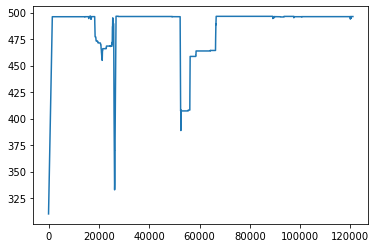

In [89]:
plt.plot(soc)

# Emissions

In [101]:
bat_old20 = 2.68 * 40087 # (kg/l)*l
bat_old50 = 2.68 * 39949 
bat_old80 = 2.68 * 39812
bat_new20 = 2.68 * 40041 
bat_new50 = 2.68 * 39903 
bat_new80 = 2.68 * 39765

print('CO2-utslipp med batteri på 20% fra start: ',bat_old20,' kg')
print('CO2-utslipp med batteri på 50% fra start: ',bat_old50,' kg')
print('CO2-utslipp med batteri på 80% fra start: ',bat_old80,' kg')

print('CO2-utslipp med batteri på 20% fra start: ',bat_new20,' kg')
print('CO2-utslipp med batteri på 50% fra start: ',bat_new50,' kg')
print('CO2-utslipp med batteri på 80% fra start: ',bat_new80,' kg')

CO2-utslipp med batteri på 20% fra start:  107433.16  kg
CO2-utslipp med batteri på 50% fra start:  107063.32  kg
CO2-utslipp med batteri på 80% fra start:  106696.16  kg
CO2-utslipp med batteri på 20% fra start:  107309.88  kg
CO2-utslipp med batteri på 50% fra start:  106940.04000000001  kg
CO2-utslipp med batteri på 80% fra start:  106570.20000000001  kg
